# QOSF Screening Task 3

### Description :

Create a quantum circuit simulator that:

- initializes states

read program, and for each gate:

- calculate matrix operator

- apply operator (modify state)

- perform multi-shot measurement of all qubits using weighted random technique

Tutorial : https://github.com/quantastica/qosf-mentorship/blob/master/qosf-simulator-task.ipynb

## Equivalent target properties in Qiskit:

In [18]:
from qiskit import*
import numpy as np
from qiskit_textbook.tools import array_to_latex

<IPython.core.display.Math object>

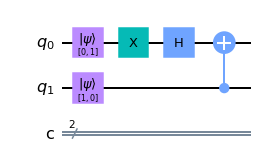

In [21]:
n = 2
qc = QuantumCircuit(n,n)

#initialize states
initial_state_0 = [0,1]
initial_state_1 = [1,0]
qc.initialize(initial_state_0, 0) 
qc.initialize(initial_state_1, 1)

#calculate matrix operator
unitary_backend = Aer.get_backend('unitary_simulator')
unitary = execute(qc,unitary_backend).result().get_unitary()
array_to_latex(unitary, pretext="\\text{Circuit = }\n")

#apply matrix operators eg.
qc.x(0)
qc.h(0)
qc.cx(1,0)

qc.draw(output='mpl')

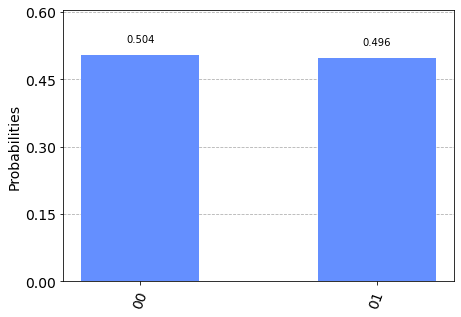

In [23]:
#perform multishot measurement
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = backend, shots = 1024).result()
counts = result.get_counts()
plot_histogram(counts)

## Implementation:

In [193]:
import numpy as np
import random
import math

In [205]:
def tensorProd(qubitsArr): 
    if(len(qubitsArr) == 1) :
        return qubitsArr[0]
    if(len(qubitsArr)>1):
        return np.kron(qubitsArr[0],calcMulQubitState(qubitsArr[1:]))
    
#apply a gate on the multi-qubit state
#input 2x2 gate, qubit idex, number of qubits
def tensorProdGate(gate,indx,n):
    #base case
    if indx == 0:
        result = gate
    else:
        result =np.identity(2)
        
    for i in range(1,n):
        if i == indx:
            result = np.kron(result,gate)
        else:
            result = np.kron(result,np.identity(2))
    return result

def calcCX(ctrl,trgt,n):
    # |0><0|
    P0x0 = np.array([[1, 0],[0, 0]])
    #|1><1|
    P1x1 = np.array([[0, 0],[0, 1]])
    X = np.array([[0, 1],[1, 0]])
    
    if(ctrl == 0):
        mat1 = P0x0
        mat2 = P1x1
    else:
        mat1 = np.identity(2)
        if(trgt == 0):
            mat2 = X
            
    for i in range(1,n):
        if(i == ctrl):
            mat1 = np.kron(mat1,P0x0)
        else:
            mat1 = np.kron(mat1,np.identity(2))
            
    for i in range(1,n):
        if(i == ctrl):
            mat2 = np.kron(mat2,P1x1)
        if(i == trgt):
            mat2 = np.kron(mat2,X)
        else:
            mat2 = np.kron(mat2,np.identity(2))
        
    return mat1+mat2


def multiShotMeasurement(meas,shots,n):
    get_bin = lambda x, n: format(x, 'b').zfill(n)
    MeasDict = {}
    #get dict of probabilities > 0
    for i in range(len(meas)):
        if(meas[i] > 0):
            MeasDict[get_bin(i, n)] = meas[i]
    
    resultsDict =  MeasDict.fromkeys(MeasDict, 0) 
    #multi shots + cumulative sum
    for i in range(shots):
        ran = random.uniform(0, 1)
        cumSum = 0
        for key, value in MeasDict.items():
            cumSum += value
            if(cumSum >= ran):
                resultsDict[key] += 1
                break
    return resultsDict


class QC():
    def __init__(self, qb):
        self.qb =qb
        #big endian -> leftmost bit is the first bit
        self.qubits = np.zeros((qb,2),dtype=np.complex_)
        self.MultiQubitState = np.zeros((2**qb,1),dtype=np.complex_)
        #gates
        self.X = np.array([[0, 1],[1, 0]])
        self.H = np.array([[1/np.sqrt(2), 1/np.sqrt(2)],[1/np.sqrt(2), -1/np.sqrt(2)]])
        self.I = np.identity(2)
        self.CX = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

        self.Operator = np.identity(2**qb)
        self.measure = np.abs(self.MultiQubitState)**2
    def x(self,QubitIndx):
        self.Operator = tensorProdGate(self.X,QubitIndx,self.qb)     
        self.MultiQubitState = self.Operator @ self.MultiQubitState
        
    def h(self,QubitIndx):
        self.Operator = tensorProdGate(self.H,QubitIndx,self.qb)  
        self.MultiQubitState = self.Operator @ self.MultiQubitState
    
    def cx(self,ctrl,trgt):
        if self.qb <2:
            raise Exception("Need at least 2 qubit system to apply CNOT")
        self.Operator = calcCX(ctrl,trgt,self.qb) 
        self.MultiQubitState = self.Operator @ self.MultiQubitState
        
    def u(self,theta,phi,lam,QubitIndx):
        gate = np.array([[math.cos(theta/2),-math.exp(complex(0,lam))*math.sin(theta/2)],[math.exp(complex(0,phi))*math.sin(theta/2),math.exp(complex(0,lam)+complex(0,phi))*math.cos(theta/2)]],dtype=np.complex_)
        self.Operator = tensorProdGate(gate,QubitIndx,self.qb)  
        self.MultiQubitState = self.Operator @ self.MultiQubitState
        
    def initialize(self,qubitIndx, value):
        self.qubits[qubitIndx] = value
    
    def updateMulQubitState(self):
        self.MultiQubitState = tensorProd(self.qubits)
    
    def getMulQubitState(self):
        return self.MultiQubitState
    
    def getMatOp(self):
        return self.Operator
    
    def measureProb(self):
        self.measure = np.abs(self.MultiQubitState)**2
        return self.measure
    
    def getCounts(self,shots):
        return multiShotMeasurement(self.measure,shots,self.qb)
        

### Execution:

In [207]:
n = 3
#initialize a circuit with 3 qubits
qc = QC(n)

#initialize states
print("\nAfter Initialization:")
qc.initialize(0,[1,0])
qc.initialize(1,[1,0])
qc.initialize(2,[1,0])

print("\nMulti Qubit State:")
qc.updateMulQubitState()
print(qc.getMulQubitState())

#Apply gates

print("\n -> Apply X:")
qc.x(2)


print("\nMulti Qubit State:")
print(qc.getMulQubitState())

print("\nMatrix Operator:")
print(qc.getMatOp())

print("\nMeasure Probability Amplitude:")
print(qc.measureProb())

print("\nMulti-shot Measurement:")
print(qc.getCounts(1024))

#--------------------------------------------

print("\nApply CNOT(0,2)")
qc.cx(0,2)
print(qc.getMatOp())

print("\nMulti Qubit State:")
print(qc.getMulQubitState())

print("\nMeasure Probability Amplitude:")
print(qc.measureProb())

print("\nMulti-shot Measurement:")
print(qc.getCounts(1024))

#----------------------------------------------

print("\n -> Apply Hadamard:")
qc.h(0)

print("\nMatrix Operator:")
print(qc.getMatOp())

print("\nMulti Qubit State:")
print(qc.getMulQubitState())

print("\nMeasure Probability Amplitude:")
print(qc.measureProb())

print("\nMulti-shot Measurement:")
print(qc.getCounts(1024))




After Initialization:

Multi Qubit State:
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

 -> Apply X:

Multi Qubit State:
[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

Matrix Operator:
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]

Measure Probability Amplitude:
[0. 1. 0. 0. 0. 0. 0. 0.]

Multi-shot Measurement:
{'001': 1024}

Apply CNOT(0,2)
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]

Multi Qubit State:
[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

Measure Probability Amplitude:
[0. 1. 0. 0. 0. 0. 0. 0.]

Multi-shot Measurement:
{'001': 1024}

 -> Apply Hadamard:

Matrix Operator:
[[ 0.70710678  0.          